<a href="https://colab.research.google.com/github/TheVioletRaven/NSE_OU/blob/master/Casus_Open_Universiteit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Notebook gemaakt door: Aukje Reina van Montfort (1704095), Silas Dannulis (2100940), Niema Mahmoudi (1807633) en Viktor Wenemoser (2101260)***

## Library imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns 
from sklearn.decomposition import PCA # wordt gebruikt voor dimensie reductie (data preparatie)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # wordt gebruikt voor normalisatie (data preparatie)
from scipy.stats import zscore # Wordt gebruikt 2 om outliers te verwijderen (data preparatie)
from sklearn.cluster import KMeans # Voor clusteranalyse
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest # Voor verwijdering outliers

In [2]:
df = 'NSE_Instellingsbestand_scaled.csv'
# Laad datasets
df_imputed = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

In [3]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def remove_outliers(scaled_data):
    # IsolationForest model for outliers verwijderen
    iso = IsolationForest(contamination=0.05)  # gewicht van outliers
    yhat = iso.fit_predict(scaled_data)
    
    # selecteer alle rijen dat geen outliers zijn
    mask = yhat != -1
    scaled_data_no_outliers = scaled_data[mask]
    
    return scaled_data_no_outliers

def process_pca(df, explained_variance_threshold=0.95):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Outlier verwijderen op scaled data
    scaled_data_no_outliers = remove_outliers(scaled_data)
    
    pca = PCA()
    pca_result = pca.fit(scaled_data_no_outliers)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(scaled_data_no_outliers))
    
    return pca_df, cumulative_variance, n_components, scaled_data_no_outliers, pca_result

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (64,), 'mlpclassifier__solver': 'sgd'}
Mean Squared Error op de testset: 0.1937657961246841
Model accuracy op de testset: 0.806234203875316
R² op de testset: -0.6272679588965981
Cross-Validation Scores: [0.82315789 0.8166491  0.79452055 0.79346681 0.79768177]
Gemiddelde Cross-Validation Score: 0.8050952248904665


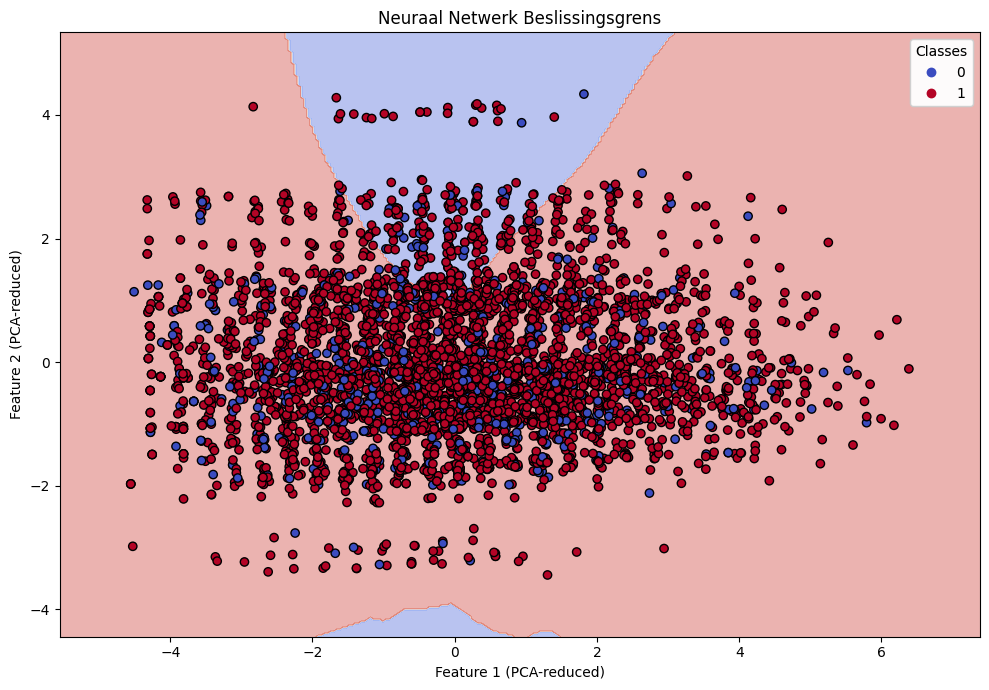

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

df = 'NSE_Instellingsbestand_scaled.csv'
# Laad datasets
df_imputed = pd.read_csv(df)

# Definiëren van de tevredenheidskolommen (hier moeten de juiste kolomnamen komen uit jouw dataset)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Relevante kolommen selecteren voor het proces
relevant_columns_nn = satisfaction_columns + ['Weegfactor', 'Jaar', 'CrohoNaamActueel_B Bedrijfskunde', 'CrohoNaamActueel_B Informatica', 
                                              'CrohoNaamActueel_B Informatiekunde', 'CrohoNaamActueel_B Milieu-natuurwetenschappen', 
                                              'CrohoNaamActueel_B Psychologie', 'CrohoNaamActueel_B Rechtsgeleerdheid']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df_imputed[relevant_columns_nn].dropna()

# Data splitsen in kenmerken (X) en doelvariabelen (y) - we gebruiken één tevredenheidskolom
X = filtered_data_nn.drop(columns=['TEVREDENHEIDALGEMEEN_01'])
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# converteren naar binair
y = (y >= y.median()).astype(int)

# Outliers verwijderen en schalen
def remove_outliers(scaled_data):
    iso = IsolationForest(contamination=0.05)
    yhat = iso.fit_predict(scaled_data)
    mask = yhat != -1
    scaled_data_no_outliers = scaled_data[mask]
    return scaled_data_no_outliers

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_no_outliers = remove_outliers(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_no_outliers, y[:X_scaled_no_outliers.shape[0]], test_size=0.2, random_state=42)

# PCA reduceren naar 2 componenten voor visualisatie
pca_visual = PCA(n_components=2)
X_train_pca_visual = pca_visual.fit_transform(X_train)
X_test_pca_visual = pca_visual.transform(X_test)

# Pipeline maken met MLPClassifier
pipeline = make_pipeline(MLPClassifier(random_state=42, max_iter=2000, tol=1e-6, activation="relu", learning_rate_init=0.01, learning_rate='adaptive', hidden_layer_sizes=[16, 16], solver="adam"))

# Hyperparameterrooster definiëren
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(accuracy_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'Model accuracy op de testset: {accuracy}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Visualisatie van het neurale netwerk
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots
xx, yy = np.meshgrid(
    np.linspace(X_train_pca_visual[:, 0].min() - 1, X_train_pca_visual[:, 0].max() + 1, 300),
    np.linspace(X_train_pca_visual[:, 1].min() - 1, X_train_pca_visual[:, 1].max() + 1, 300)
)
D = np.c_[xx.ravel(), yy.ravel()]

# Voorspellingen maken over de mesh grid met het visuele PCA-model
Z = best_model.predict(pca_visual.inverse_transform(D))
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_pca_visual[:, 0], X_train_pca_visual[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Classes")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens")
ax2.set_xlabel('Feature 1 (PCA-reduced)')
ax2.set_ylabel('Feature 2 (PCA-reduced)')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Laad de dataset
df = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

# Definiëren van de tevredenheidskolommen (doelvariabelen)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Definiëren van de kenmerken (X)
relevant_columns_nn = satisfaction_columns + ['INHOUDOPZET_THEMA', 'AANSLUITING_THEMA', 'DOCENTEN_THEMA', 
                                              'BEGELEIDING_THEMA', 'TOETSINGBEOORDELING_THEMA', 
                                              'BETROKKENHEIDCONTACT_THEMA', 'STUDIEDRUK_01', 
                                              'VAARDIGHEDEN_THEMA', 'STUDIELAST_THEMA', 
                                              'STUDIEFACILITEITEN_THEMA']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df[relevant_columns_nn].dropna()

# Kenmerken (X) en doelvariabelen (y) definiëren
X = filtered_data_nn.drop(columns=satisfaction_columns)
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline maken met StandardScaler, PCA en MLPRegressor
pipeline = Pipeline([
    ('pca', PCA(n_components=2)),  # PCA toevoegen aan de pipeline
    ('mlpregressor', MLPRegressor(random_state=42, max_iter=2000, tol=1e-6, learning_rate_init=0.01, learning_rate='adaptive', solver="adam"))
])

# Hyperparameterrooster definiëren
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Toon enkele voorspellingen naast de werkelijke waarden
for i in range(10):
    print(f'Werkelijke waarde: {y_test.iloc[i]}, Voorspelde waarde: {y_pred[i]}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (64,), 'mlpregressor__solver': 'sgd'}
Mean Squared Error op de testset: 0.022870327783948322
R² op de testset: 0.43126802822311683
Cross-Validation Scores: [0.38836146 0.45399171 0.49505066 0.37582799 0.344399  ]
Gemiddelde Cross-Validation Score: 0.41152616384486607
Werkelijke waarde: 1.0, Voorspelde waarde: 0.875623172390367
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8254334338667256
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8704422976136769
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8565207292784376
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8497220465196971
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8981760135630337
Werkelijke waarde: 0.75, Voorspelde waarde: 0.6867504862058473
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9355094469266765
Werkelijke waarde: 0.5, Voorspelde waarde: 0.43

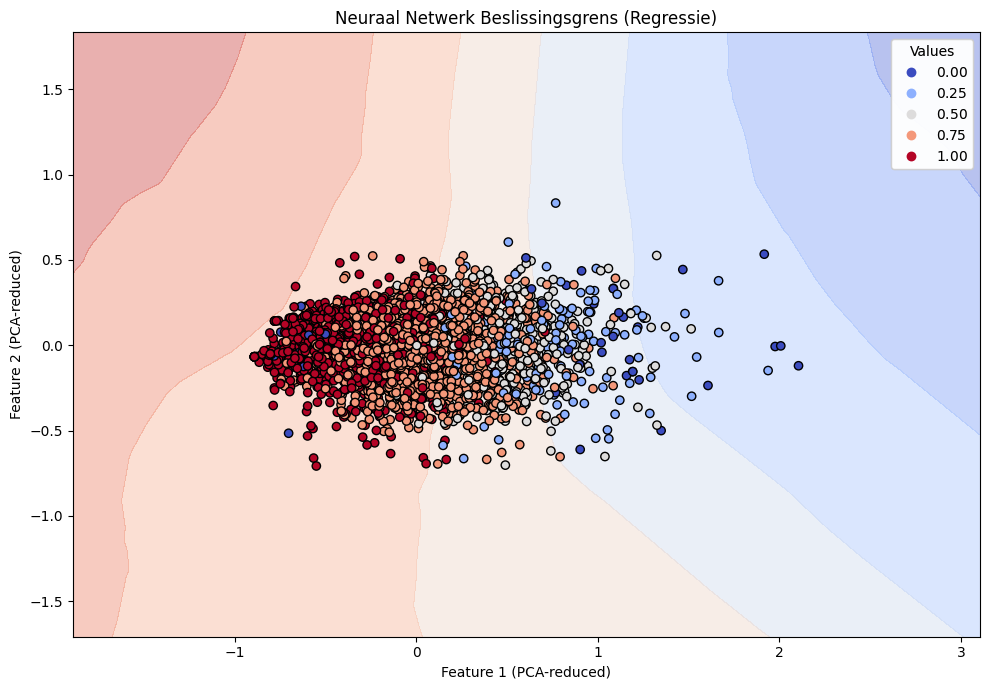

In [13]:
# Visualisatie van het neurale netwerk
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots
pca_visual = best_model.named_steps['pca']
X_train_pca_visual = pca_visual.transform(X_train)

xx, yy = np.meshgrid(
    np.linspace(X_train_pca_visual[:, 0].min() - 1, X_train_pca_visual[:, 0].max() + 1, 300),
    np.linspace(X_train_pca_visual[:, 1].min() - 1, X_train_pca_visual[:, 1].max() + 1, 300)
)
D = np.c_[xx.ravel(), yy.ravel()]

# Toepassen van de volledige pipeline op de mesh grid data
Z = best_model.named_steps['mlpregressor'].predict(D)
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_pca_visual[:, 0], X_train_pca_visual[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Values")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens (Regressie)")
ax2.set_xlabel('Feature 1 (PCA-reduced)')
ax2.set_ylabel('Feature 2 (PCA-reduced)')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Laad de dataset
df = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

# Definiëren van de tevredenheidskolommen (doelvariabelen)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Definiëren van de kenmerken (X)
relevant_columns_nn = satisfaction_columns + ['INHOUDOPZET_THEMA', 'AANSLUITING_THEMA', 'DOCENTEN_THEMA', 
                                              'BEGELEIDING_THEMA', 'TOETSINGBEOORDELING_THEMA', 
                                              'BETROKKENHEIDCONTACT_THEMA', 'STUDIEDRUK_01', 
                                              'VAARDIGHEDEN_THEMA', 'STUDIELAST_THEMA', 
                                              'STUDIEFACILITEITEN_THEMA']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df[relevant_columns_nn].dropna()

# Kenmerken (X) en doelvariabelen (y) definiëren
X = filtered_data_nn.drop(columns=satisfaction_columns)
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline maken met StandardScaler en MLPRegressor
pipeline = Pipeline([
    ('mlpregressor', MLPRegressor(random_state=42, max_iter=2000, tol=1e-6, learning_rate_init=0.01, learning_rate='adaptive', solver="adam"))
])

# Hyperparameterrooster definiëren
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Toon enkele voorspellingen naast de werkelijke waarden
for i in range(10):
    print(f'Werkelijke waarde: {y_test.iloc[i]}, Voorspelde waarde: {y_pred[i]}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.0001, 'mlpregressor__hidden_layer_sizes': (64, 32), 'mlpregressor__solver': 'sgd'}
Mean Squared Error op de testset: 0.02052157616025859
R² op de testset: 0.48967602983876324
Cross-Validation Scores: [0.44699112 0.49675545 0.53210741 0.41339865 0.36408965]
Gemiddelde Cross-Validation Score: 0.4506684574571513
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8373561769815902
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8326129930412384
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9154718963415808
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8128757348954255
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8399820551674583
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9128648232005193
Werkelijke waarde: 0.75, Voorspelde waarde: 0.7591298610307553
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9726091270251939
Werkelijke waarde: 0.5, Voorspelde waarde: 

C:\Users\sdann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


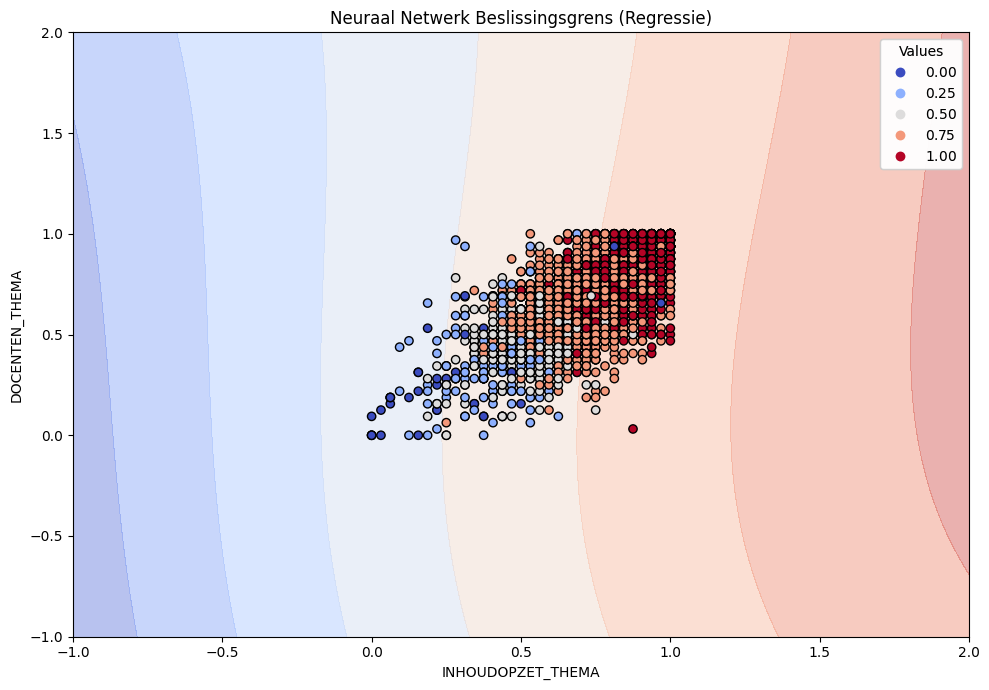

In [29]:
# Visualisatie van het neurale netwerk zonder PCA
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots met de eerste twee features
X_train_subset = X_train[['INHOUDOPZET_THEMA', 'DOCENTEN_THEMA']]  # Gebruik de eerste twee features voor visualisatie

xx, yy = np.meshgrid(
    np.linspace(X_train_subset.iloc[:, 0].min() - 1, X_train_subset.iloc[:, 0].max() + 1, 300),
    np.linspace(X_train_subset.iloc[:, 1].min() - 1, X_train_subset.iloc[:, 1].max() + 1, 300)
)
D = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_train_subset.columns)

# Vul de ontbrekende kolommen in met het gemiddelde van de trainingsdata
for col in X_train.columns:
    if col not in D.columns:
        D[col] = X_train[col].mean()

# Voorspellingen maken met de beste MLPRegressor
Z = best_model.named_steps['mlpregressor'].predict(D)
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_subset.iloc[:, 0], X_train_subset.iloc[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Values")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens (Regressie)")
ax2.set_xlabel('INHOUDOPZET_THEMA')
ax2.set_ylabel('DOCENTEN_THEMA')

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (128, 64), 'mlpregressor__solver': 'sgd'}
Mean Squared Error op de testset: 0.02071370359736547
R² op de testset: 0.4848982663903999
Cross-Validation Scores: [0.44237299 0.47893924 0.51543661 0.40554556 0.36088309]
Gemiddelde Cross-Validation Score: 0.4406354978140447
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8119264606858698
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8342972286046026
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8953330612906422
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8220778698630357
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8528095709488007
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9116329211857979
Werkelijke waarde: 0.75, Voorspelde waarde: 0.802179956937641
Werkelijke waarde: 1.0, Voorspelde waarde: 0.940482298347637
Werkelijke waarde: 0.5, Voorspelde waarde: 0.40

C:\Users\sdann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


ValueError: X has 2 features, but MLPRegressor is expecting 10 features as input.

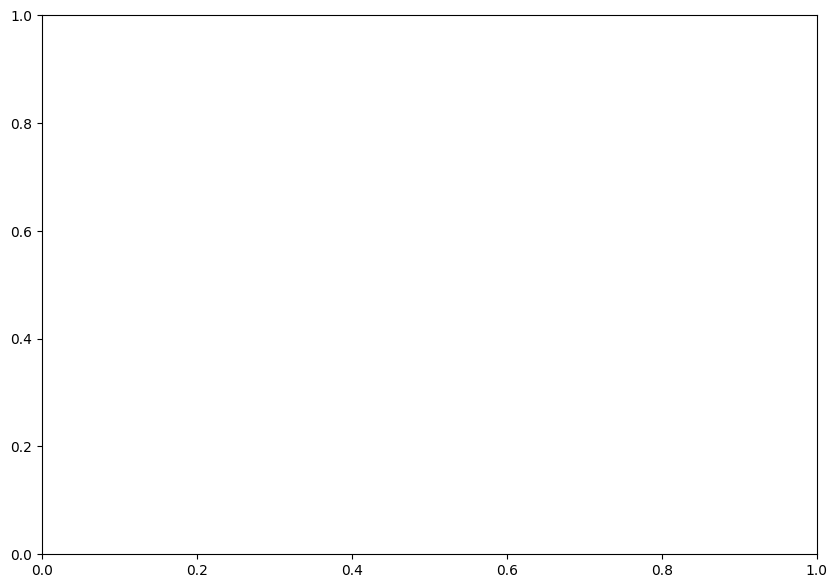

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Laad de dataset
df = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

# Definiëren van de tevredenheidskolommen (doelvariabelen)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Definiëren van de kenmerken (X)
relevant_columns_nn = satisfaction_columns + ['INHOUDOPZET_THEMA', 'AANSLUITING_THEMA', 'DOCENTEN_THEMA', 
                                              'BEGELEIDING_THEMA', 'TOETSINGBEOORDELING_THEMA', 
                                              'BETROKKENHEIDCONTACT_THEMA', 'STUDIEDRUK_01', 
                                              'VAARDIGHEDEN_THEMA', 'STUDIELAST_THEMA', 
                                              'STUDIEFACILITEITEN_THEMA']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df[relevant_columns_nn].dropna()

# Kenmerken (X) en doelvariabelen (y) definiëren
X = filtered_data_nn.drop(columns=satisfaction_columns)
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Specifieke kolommen voor visualisatie selecteren
visualization_columns = ['INHOUDOPZET_THEMA', 'DOCENTEN_THEMA']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline maken met StandardScaler en MLPRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlpregressor', MLPRegressor(random_state=42, max_iter=2000, tol=1e-6, learning_rate_init=0.01, learning_rate='adaptive', solver="adam"))
])

# Hyperparameterrooster definiëren
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Toon enkele voorspellingen naast de werkelijke waarden
for i in range(10):
    print(f'Werkelijke waarde: {y_test.iloc[i]}, Voorspelde waarde: {y_pred[i]}')

# Visualisatie van het neurale netwerk
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots met de specifieke kolommen
X_train_subset = X_train[visualization_columns]

xx, yy = np.meshgrid(
    np.linspace(X_train_subset.iloc[:, 0].min() - 1, X_train_subset.iloc[:, 0].max() + 1, 300),
    np.linspace(X_train_subset.iloc[:, 1].min() - 1, X_train_subset.iloc[:, 1].max() + 1, 300)
)
D = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=visualization_columns)

# Voorspellingen maken met de beste MLPRegressor
Z = best_model.named_steps['mlpregressor'].predict(D)
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_subset.iloc[:, 0], X_train_subset.iloc[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Values")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens (Regressie)")
ax2.set_xlabel('INHOUDOPZET_THEMA')
ax2.set_ylabel('DOCENTEN_THEMA')

plt.tight_layout()
plt.show()
